In [39]:
%matplotlib inline
import quantstats as qs

# extend pandas functionality with metrics, etc.
qs.extend_pandas()

# Load environment variables
from dotenv import load_dotenv
import os
from pathlib import Path

# Load environment variables
from dotenv import load_dotenv
import os
from pathlib import Path

# Load .env file from current directory
env_path = Path('.env')
load_dotenv(env_path)

True

In [40]:
import pandas as pd

# Salva i metodi originali
_original_series_resample = pd.Series.resample
_original_dataframe_resample = pd.DataFrame.resample

def patched_series_resample(self, rule, *args, **kwargs):
    if rule == "YE":
        rule = "Y"
    elif rule == "ME":
        rule = "M"
    elif rule == "QE":
        rule = "Q"
    return _original_series_resample(self, rule, *args, **kwargs)

def patched_dataframe_resample(self, rule, *args, **kwargs):
    if rule == "YE":
        rule = "Y"
    elif rule == "ME":
        rule = "M"
    elif rule == "QE":
        rule = "Q"
    return _original_dataframe_resample(self, rule, *args, **kwargs)

pd.Series.resample = patched_series_resample
pd.DataFrame.resample = patched_dataframe_resample

In [41]:
# import pandas as pd
from pandas.core.resample import Resampler

# Patch per evitare axis=0 su Resampler.sum()
_original_resampler_sum = Resampler.sum

def patched_resampler_sum(self, *args, **kwargs):
    # Rimuovi axis se presente e chiama sum senza argomenti
    kwargs.pop('axis', None)
    return _original_resampler_sum(self, *args, **kwargs)

Resampler.sum = patched_resampler_sum

In [42]:
# Get path from environment variables
path_daily_returns_strategies = os.getenv('path_daily_returns_strategies')
path_daily_returns_spy = os.getenv('path_daily_returns_spy')

daily_returns_spy = pd.read_csv(path_daily_returns_spy, index_col=0, parse_dates=True, sep=';')
daily_returns_strategies = pd.read_csv(path_daily_returns_strategies, index_col=0, parse_dates=True, sep=';')

# Fix: Normalize dates to remove time component
daily_returns_spy.index = daily_returns_spy.index.normalize()
daily_returns_strategies.index = daily_returns_strategies.index.normalize()

In [43]:
# rename the columns
daily_returns_spy.columns = ['daily_returns_spy']
daily_returns_strategies.columns = ['daily_returns_strategies']

In [44]:
daily_returns_spy

,daily_returns_spy
datetime,
2023-04-19,NaN
2023-04-20,-0.005457
2023-04-21,0.000777
2023-04-24,0.001043
2023-04-25,-0.015874
...,...
2025-09-19,0.002174
2025-09-22,0.004731
2025-09-23,-0.005444


In [45]:
daily_returns_strategies

,daily_returns_strategies
Date,
2023-04-17,0.053095
2023-04-18,-0.000460
2023-04-19,-0.005545
2023-04-20,-0.000670
2023-04-21,0.004506
...,...
2025-09-16,0.000045
2025-09-17,-0.000511
2025-09-18,0.000020


In [46]:
# # Debug the merge issue
# print("SPY DataFrame info:")
# print(f"Shape: {daily_returns_spy.shape}")
# print(f"Date range: {daily_returns_spy.index.min()} to {daily_returns_spy.index.max()}")
# print(f"Has NaN values: {daily_returns_spy.isna().sum().sum()}")
# print("\nStrategies DataFrame info:")
# print(f"Shape: {daily_returns_strategies.shape}")
# print(f"Date range: {daily_returns_strategies.index.min()} to {daily_returns_strategies.index.max()}")
# print(f"Has NaN values: {daily_returns_strategies.isna().sum().sum()}")

# # Check for overlapping dates
# common_dates = daily_returns_spy.index.intersection(daily_returns_strategies.index)
# print(f"\nNumber of common dates: {len(common_dates)}")

# if len(common_dates) > 0:
#     print(f"Common date range: {common_dates.min()} to {common_dates.max()}")
# else:
#     print("No overlapping dates found!")
#     print("\nSPY sample dates:")
#     print(daily_returns_spy.index[:5].tolist())
#     print("\nStrategies sample dates:")
#     print(daily_returns_strategies.index[:5].tolist())

# # Try a different merge approach
# merged_df = pd.merge(daily_returns_spy, daily_returns_strategies, left_index=True, right_index=True, how='inner')
# print(f"\nMerged DataFrame shape before dropna: {merged_df.shape}")

# # Check what's in the merged dataframe before dropping NAs
# print(f"NaN count in merged_df:")
# print(merged_df.isna().sum())

# # Drop NA values
# merged_df = merged_df.dropna()
# print(f"Merged DataFrame shape after dropna: {merged_df.shape}")

# # Only try to sample if we have data
# if len(merged_df) > 0:
#     print(f"\nSample of merged data:")
#     sample_size = min(10, len(merged_df))
#     print(merged_df.sample(sample_size))
# else:
#     print("No data available after merge and dropna!")

In [47]:
# merge the two dataframes on the index (now with normalized dates)
merged_df = pd.merge(daily_returns_spy, daily_returns_strategies, left_index=True, right_index=True, how='inner')

# drop na values
merged_df = merged_df.dropna()

print(f"Merged DataFrame shape: {merged_df.shape}")
merged_df

Merged DataFrame shape: (541, 2)


,daily_returns_spy,daily_returns_strategies
2023-04-20,-0.005457,-0.000670
2023-04-21,0.000777,0.004506
2023-04-24,0.001043,-0.008464
2023-04-26,-0.004236,0.058882
2023-04-28,0.008535,0.000161
...,...,...
2025-09-16,-0.001377,0.000045
2025-09-17,-0.001242,-0.000511
2025-09-18,0.004672,0.000020
2025-09-22,0.004731,-0.000484


In [48]:
# Safe sampling - check if DataFrame has data first
if len(merged_df) > 0:
    sample_size = min(10, len(merged_df))
    merged_df.sample(sample_size)
else:
    print("No data available in merged_df")

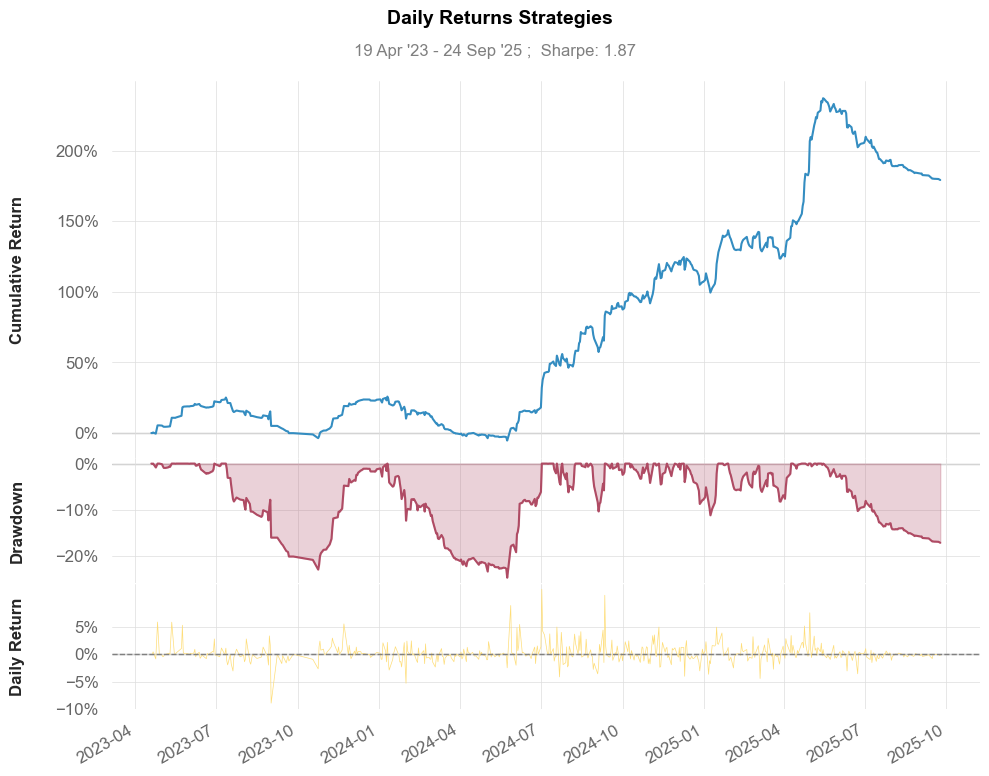

In [49]:
# plot daily_returns_strategies
qs.plots.snapshot(merged_df['daily_returns_strategies'], title='Daily Returns Strategies', show=True)


In [50]:
# shows basic/full metrics
qs.reports.metrics(benchmark=merged_df['daily_returns_spy'],
                   returns=merged_df['daily_returns_strategies'],
                   mode='basic',
                   title='Daily Returns Strategies',
                   display=True,
                   download=True,
                   output='daily_returns_strategies.html')

RecursionError: maximum recursion depth exceeded

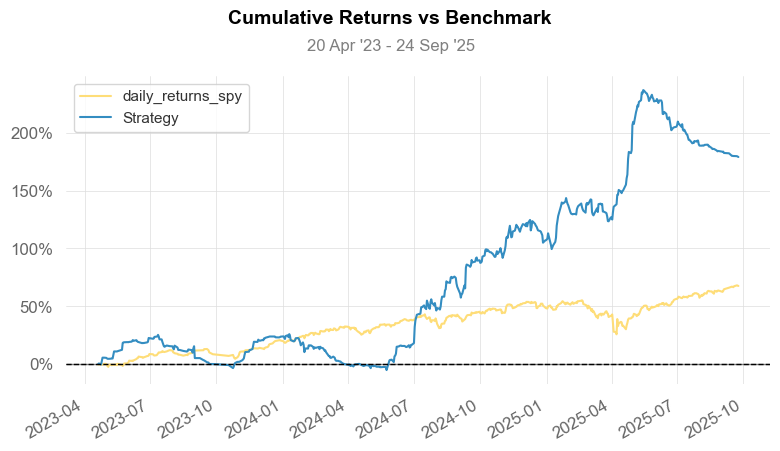

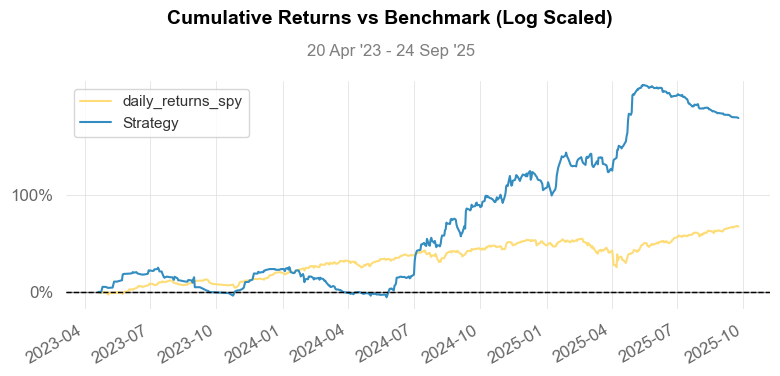

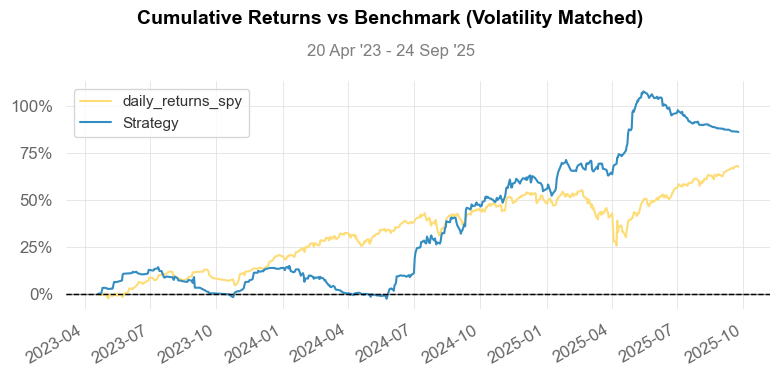

RecursionError: maximum recursion depth exceeded

In [51]:
# shows basic/full plots
qs.reports.plots(returns=merged_df['daily_returns_strategies'],
                  benchmark=merged_df['daily_returns_spy'],
                  mode='full',
                  title='Daily Returns Strategies',
                  display=True,
                  download=True,
                  output='daily_returns_strategies.html')

In [52]:
# shows basic metrics and plots
qs.reports.basic(returns=merged_df['daily_returns_strategies'],
                  benchmark=merged_df['daily_returns_spy'],
                  mode='basic',
                  title='Daily Returns Strategies',
                  display=True,
                  download=True,
                  output='daily_returns_strategies.html')

RecursionError: maximum recursion depth exceeded

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2023-04-20   2023-04-20
End Period                 2025-05-15   2025-05-15
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          48.22%       157.91%
CAGR﹪                     14.02%       37.14%

Sharpe                     1.38         2.2
Prob. Sharpe Ratio         97.2%        99.96%
Smart Sharpe               1.35         2.14
Sortino                    2.1          4.4
Smart Sortino              2.04         4.29
Sortino/√2                 1.48         3.11
Smart Sortino/√2           1.44         3.03
Omega                      1.67         1.67

Max Drawdown               -19.86%      -20.68%
Longest DD Days            85           173
Volatility (ann.)          16.88%       25.46%
R^2                        0.0          0.0
Information Ratio          0.07         0.07
Calmar               

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2023-07-13,2023-10-24,2023-11-27,138,-20.682005,-19.569475
2,2024-01-11,2024-05-24,2024-07-01,173,-19.986515,-19.791588
3,2024-07-12,2024-08-01,2024-09-10,61,-13.675886,-12.686537
4,2024-12-13,2025-01-08,2025-01-14,33,-6.238482,-5.699320
5,2025-02-03,2025-03-05,2025-03-07,33,-4.094884,-3.758308


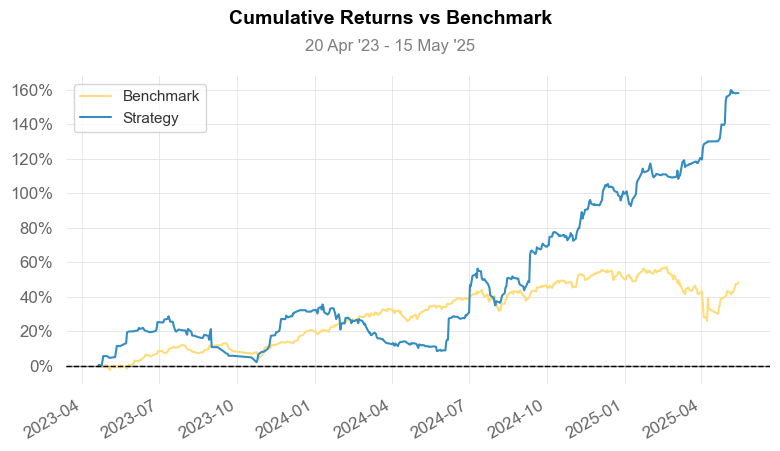

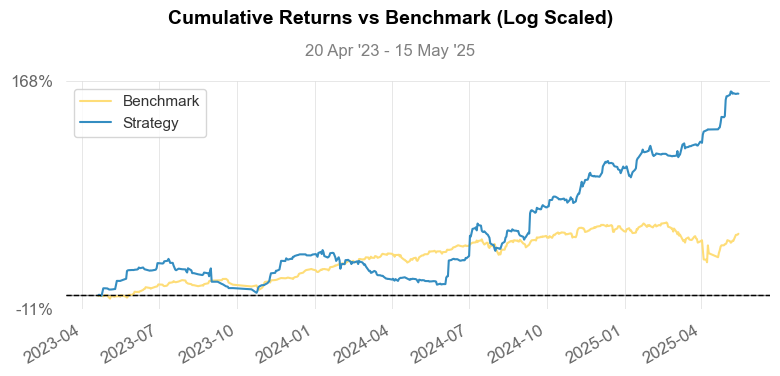

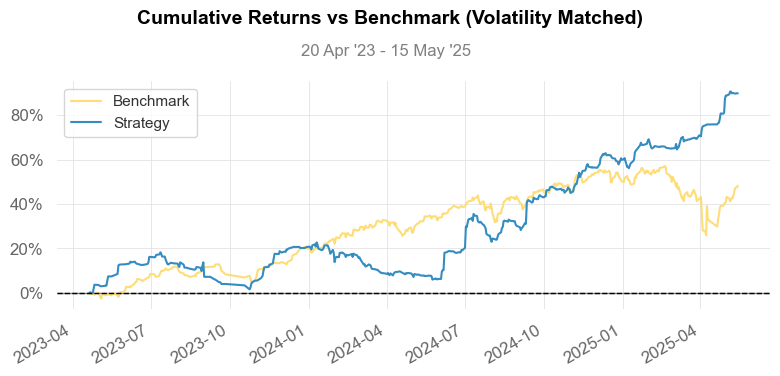

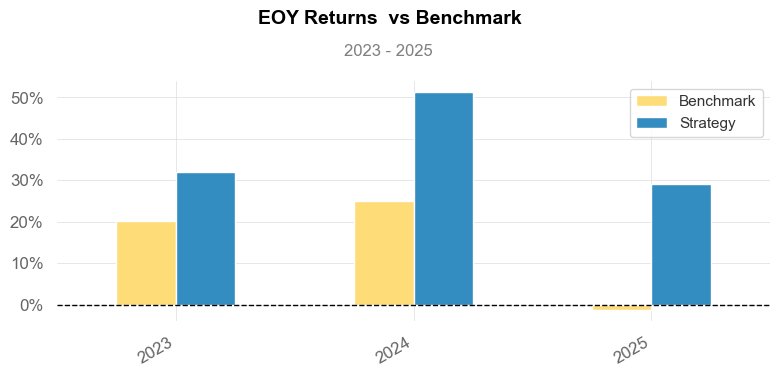

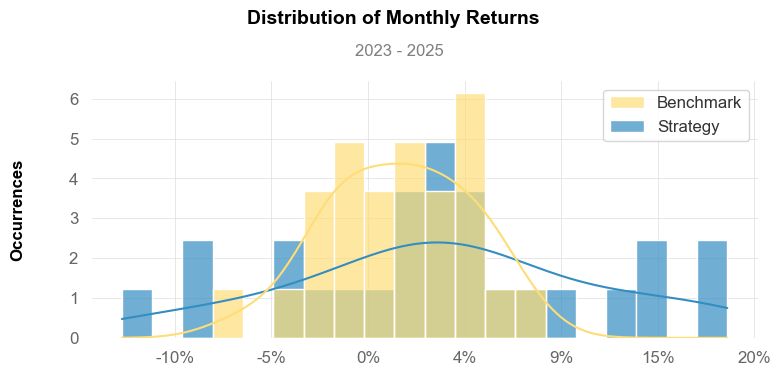

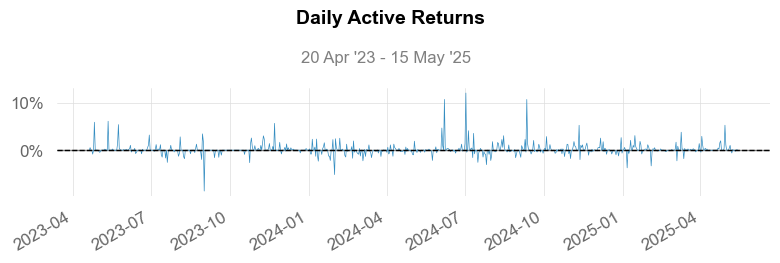

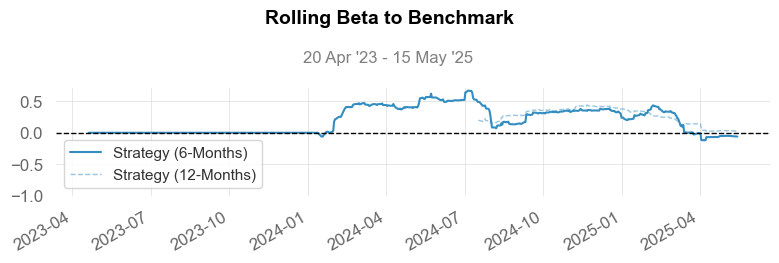

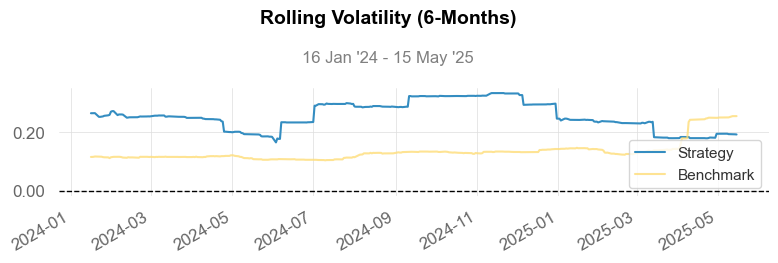

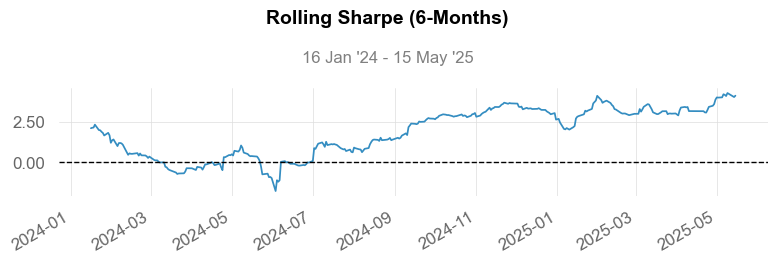

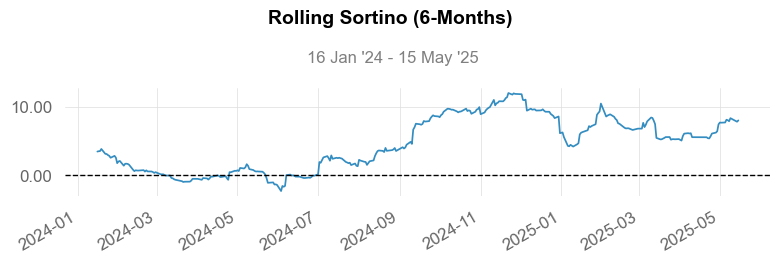

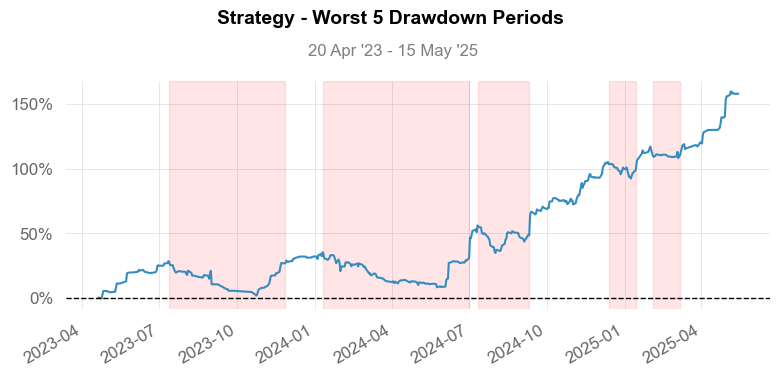

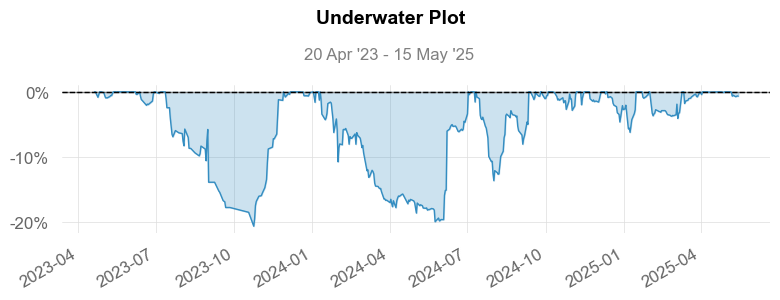

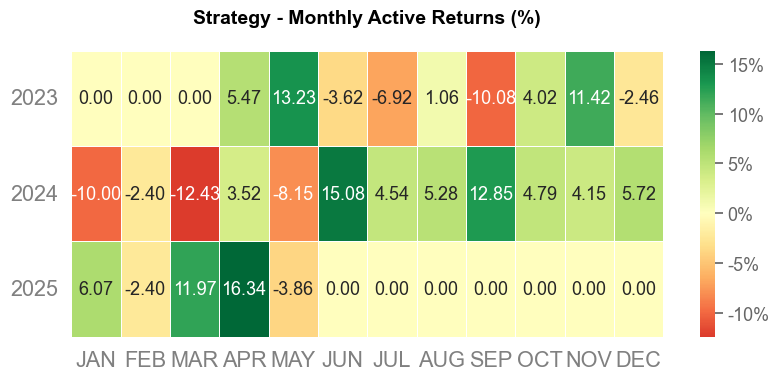

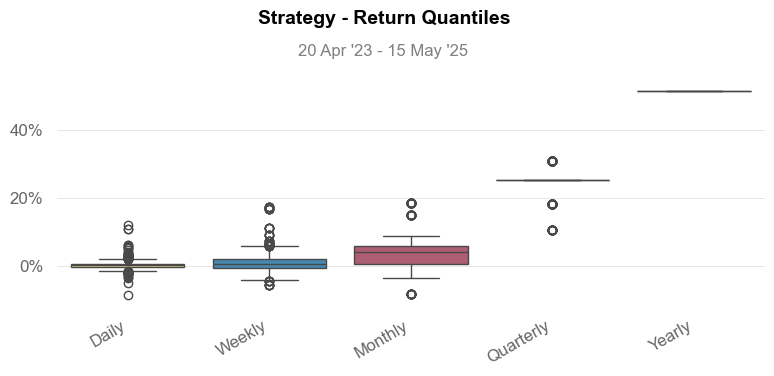

In [ ]:
# shows full metrics and plots
qs.reports.full(returns=merged_df['daily_returns_strategies'],
                  benchmark=merged_df['daily_returns_spy'],
                  mode='full',
                  title='Daily Returns Strategies',
                  display=True,
                  download=True,
                  output='daily_returns_strategies.html')

In [ ]:
# generates a complete report as html
qs.reports.html(returns=merged_df['daily_returns_strategies'],
                 benchmark=merged_df['daily_returns_spy'],
                 title='Daily Returns Strategies',
                 display=True,
                 download=True,
                 output='daily_returns_strategies.html')